<a href="https://colab.research.google.com/github/mayankkumar15/Virtual-Trial-Mirror/blob/main/viton_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an implementation of the [VITON GAN](https://arxiv.org/abs/1911.07926) using Python, it combines LIP and Openpose to create a fully functional pipeline from image input to procesing to final output.

In [ ]:
%cd '/content/drive/My Drive/Viton'

/content/drive/My Drive/Viton


In [ ]:
!pip install ninja

In [ ]:
#Please select images which you want to upload
%cd data/test/person
from google.colab import files
uploaded = files.upload()
%cd ..

# Look Into Person for Human Segmentation

In [ ]:
!python3 "/content/drive/My Drive/Viton/LIP/Self-Correction-Human-Parsing/simple_extractor.py" --dataset 'lip' --model-restore '/content/drive/My Drive/Viton/LIP/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/My Drive/Viton/data/test/person' --output-dir '/content/drive/My Drive/Viton/data/test/person-parse'

# OpenPose for Pose Detection

In [ ]:
%cd '/content/drive/My Drive/Viton'
import cv2
import time
import numpy as np
import json
import os
from google.colab.patches import cv2_imshow

MODE = "COCO"

if MODE is "COCO":
    protoFile = "OpenPose/pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "OpenPose/pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "OpenPose/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "OpenPose/pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]


frame = cv2.imread("data/test/person/"+list(uploaded.keys())[0])
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

t = time.time()
# input image dimensions for the network
inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
print("time taken by network : {:.3f}".format(time.time() - t))

H = output.shape[2]
W = output.shape[3]

# Empty list to store the detected keypoints
pointsb = []
pointsa = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        pointsb.append((int(x), int(y)))
        pointsa.extend((int(x), int(y), prob))
    else :
        pointsb.append((0,0,0))
        pointsa.extend((0,0,0))

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if pointsb[partA] != (0,0,0)  and pointsb[partB] != (0,0,0):
        cv2.line(frame, pointsb[partA], pointsb[partB], (0, 255, 255), 2)
        cv2.circle(frame, pointsb[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

cv2_imshow(frameCopy)
cv2_imshow(frame)


cv2.imwrite('Output-Keypoints.jpg', frameCopy)
cv2.imwrite('Output-Skeleton.jpg', frame)

print("Total time taken : {:.3f}".format(time.time() - t))

print(pointsa)

data = {}
data['version'] = 1.0
data['people'] = []
data['people'].append({
    'face_keypoints': [] ,
    'pose_keypoints': pointsa,
    'hand_right_keypoints': [], 
    'hand_left_keypoints': []
})

jsnfn = "/content/drive/My Drive/Viton/data/test/pose/" + os.path.splitext(list(uploaded.keys())[0])[0] + '_keypoints.json'
with open(jsnfn, 'w') as outfile:
    json.dump(data, outfile)

cv2.waitKey(0)



# Executing the model

In [ ]:
#@title choose cloth
#@markdown ![cloth](https://drive.google.com/uc?id=1BkdCWtTdYyctP2WxNNuzPxrzVv6k_UIt)

#@markdown Enter the ID of the cloth to try:
text = '008250_1.jpg' #@param {type:"string"}
f = open("/content/drive/My Drive/Viton/data/test_pairs.txt", "w")
f.write(list(uploaded.keys())[0] + " " + text)
f.close()


## Virtual trial room GAN

In [ ]:
!python '/content/drive/My Drive/Viton/viton-gan/viton_gan/run_gmm.py'

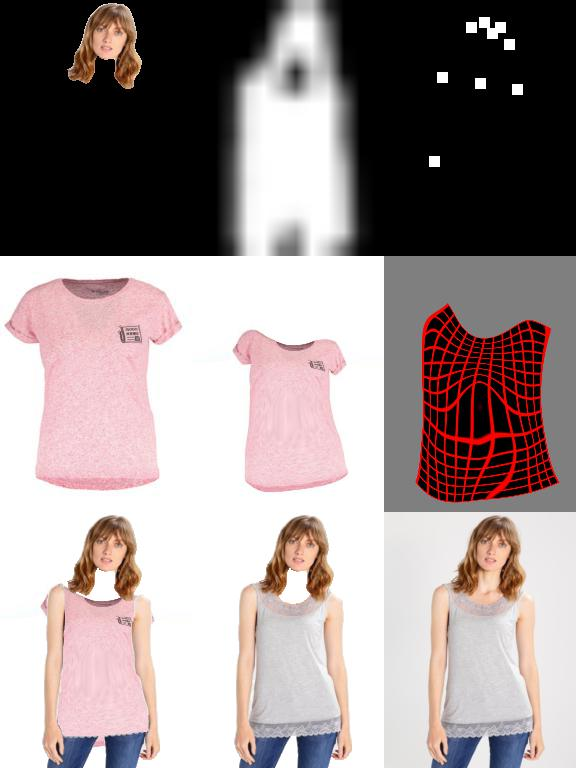

In [ ]:
gmmop = cv2.imread("/content/drive/My Drive/Viton/viton-gan/result/GMM/test/"+text)
cv2_imshow(gmmop)

In [ ]:
!python '/content/drive/My Drive/Viton/viton-gan/viton_gan/run_tom.py'

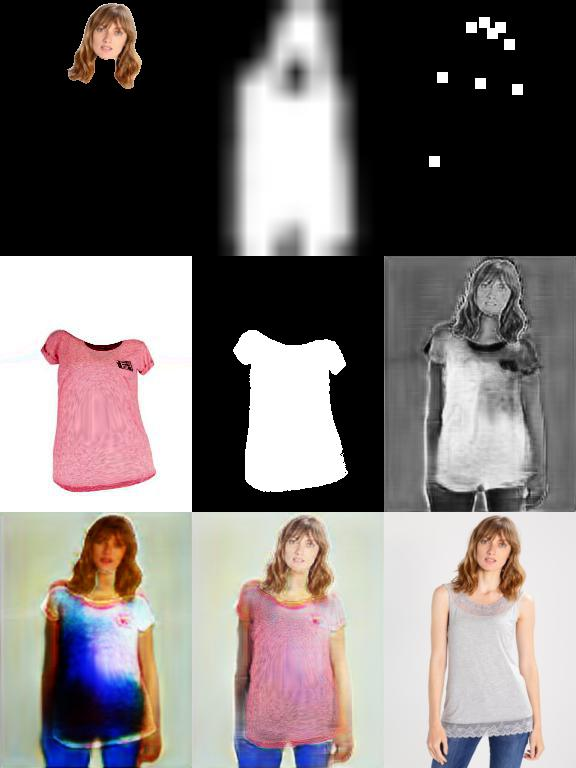

In [ ]:
tomop = cv2.imread("/content/drive/My Drive/Viton/viton-gan/result/TOM/test/"+text)
cv2_imshow(tomop)

The 5th image that is the image in the middle of the second row is the final image generated by the GAN